## Link analysis
**DISCLAIMER: This code is not verified and may contain errors.**

**Description:** 

This notebook contains the code for the link analysis used for the link budget calculations used in my thesis.
The variables in the next cell can be changed to calculate the link budget for different scenarios.



In [4]:
import numpy as np

# Constants
c = 3e8 # m/s                               speed of light
Re = 6378e3 # m                             radius of earth


# Variables
Uplink_frequency = 435e6 # Hz               frequency of the uplink signal
Downlink_frequency = 435e6 # Hz             frequency of the downlink signal

satellite_altitude = 400e3 # m              altitude of the satellite

Cubesat_transmitter_power = -10 # dBW       cubesat transmitter power
Cubesat_antenna_gain = 2.15 # dBi           cubesat antenna gain
Cubesat_line_loss = 0 # dB                  line losses

Ground_station_transmitter_power = 10 # dBW ground station transmitter power
Ground_station_antenna_gain = 15 # dBi      ground station antenna gain
Ground_station_line_loss = 2 # dB           line losses

Uplink_atmospheric_loss = 0.5 # dB          atmospheric losses
Downlink_atmospheric_loss = 0.5 # dB        atmospheric losses
polarization_loss = 3 # dB                  polarization losses
Ground_station_pointing_loss = 0 # dB       ground station pointing losses

Effective_noise_temperature_cube = 470 # K  effective noise temperature of the cubesat
Effective_noise_temperature_gs = 1000 # K   effective noise temperature of the ground station

bandwidth = 12e2 # Hz                       bandwidth of the signal
EB_NO_req = 10 # dB                         required energy per bit to noise density ratio


EIRP_cubesat = Cubesat_transmitter_power + Cubesat_antenna_gain # dB
EIRP_station = Ground_station_transmitter_power + Ground_station_antenna_gain # dB

In [5]:
def calculate_distance_to_satellite(angle, degrees=False, unit='m'):
    # this function calculates the distance to the satellite given the angle between the satellite and the ground station
    if degrees: angle = np.deg2rad(angle)
    if(unit == 'km'): return ((Re*np.sin(angle)*-1) + np.sqrt((Re * np.sin(angle))**2+ 2*Re*satellite_altitude + satellite_altitude**2))/1000
    else: return (Re*np.sin(angle)*-1) + np.sqrt((Re * np.sin(angle))**2+ 2*Re*satellite_altitude + satellite_altitude**2)

def free_space_path_loss(frequency, distance):
    # Calculates the free space path loss in dB
    return 20 * np.log10(frequency) + 20 * np.log10(distance) + 20 * np.log10(4 * np.pi / c )

def dipole_radiation_pattern_db(theta, degrees=False):
    # Calculates the dipole radiation pattern in dBi based the angle
    if degrees: theta = np.deg2rad(theta)
    return 10*np.log10(((np.cos((np.pi/2)*np.cos(theta))) /(np.sin(theta)))**2)+2.15

def calculate_depiontning_loss(epsilon, degrees=False):
    # Calculates the depointing loss in dBi based on the angle between the satellite and the ground station
    if degrees: epsilon = np.deg2rad(epsilon)
    n = np.arcsin((Re*np.cos(epsilon))/(Re+satellite_altitude))
    return dipole_radiation_pattern_db((np.pi/2)-n)

def isotropic_received_power(EIRP, fspl, polarisation_loss, atmospheric_loss, depointing_loss):
    # Calculates the isotropic received power in dBW
    return EIRP - fspl - polarisation_loss - atmospheric_loss - depointing_loss

def figure_of_merit(gain, losses, temperature):
    # Calculates the figure of merit in dB/K
    return gain - losses - 10*np.log10(temperature)

def noise_power(temperature, bandwidth):
    # Calculates the noise power in dBW
    return 10*np.log10(1.38e-23*temperature*bandwidth)


In [6]:

angle = 90
d = calculate_distance_to_satellite(angle, True)
fspl = free_space_path_loss(Downlink_frequency, d)
iso_pwr = isotropic_received_power(EIRP_cubesat, fspl, polarization_loss, Downlink_atmospheric_loss, -1*(calculate_depiontning_loss(angle, True)-2.15))
received_power = iso_pwr - Ground_station_pointing_loss + Ground_station_antenna_gain - Ground_station_line_loss

print("Downlink")
print("Elevation angle(°): ", angle)
print("Distance to satellite (km): ", calculate_distance_to_satellite(angle, True, 'km'))
print("Frequency (MHz): " , Downlink_frequency/1e6)
print("---Cubesat---")
print("Transmitter power (dBW): ", Cubesat_transmitter_power)
print("Antenna gain (dBi): ", Cubesat_antenna_gain)
print("Cubesat EIRP (dBW): ", EIRP_cubesat)
print("---Channel---")
print("Cubesat pointing loss (dB): ", -1*(calculate_depiontning_loss(angle, True)-2.15))
print("polarization loss (dB): ", polarization_loss)
print("Atmospheric loss (dB): ", Downlink_atmospheric_loss)
print("Free space path loss (dB): ", fspl)
print("Isotropic received power (dBW): ", iso_pwr)
print("---Ground station---")
print("Ground station pointing loss (dB): ", Ground_station_pointing_loss)
print("Antenna gain (dBi): ", Ground_station_antenna_gain)
print("Ground station line loss (dB): ", Ground_station_line_loss)
print("Effective_noise_temperature_gs (K): ", Effective_noise_temperature_gs)
print("Figure of merit (dB/K): ", figure_of_merit(Ground_station_antenna_gain, Ground_station_line_loss, Effective_noise_temperature_gs))
print("Received power (dBW): ", received_power)
print("Power noise temperature (dBW): ", noise_power(Effective_noise_temperature_gs, bandwidth))
print('Signal to noise ratio (dB): ', received_power - noise_power(Effective_noise_temperature_gs, bandwidth))
print("SNR requirement (dB): ", EB_NO_req)
print("Margin (dB): ", received_power - noise_power(Effective_noise_temperature_gs, bandwidth) - EB_NO_req)

Downlink
Elevation angle(°):  90
Distance to satellite (km):  400.0
Frequency (MHz):  435.0
---Cubesat---
Transmitter power (dBW):  -10
Antenna gain (dBi):  2.15
Cubesat EIRP (dBW):  -7.85
---Channel---
Cubesat pointing loss (dB):  -0.0
polarization loss (dB):  3
Atmospheric loss (dB):  0.5
Free space path loss (dB):  137.25275715170068
Isotropic received power (dBW):  -148.60275715170067
---Ground station---
Ground station pointing loss (dB):  0
Antenna gain (dBi):  15
Ground station line loss (dB):  2
Effective_noise_temperature_gs (K):  1000
Figure of merit (dB/K):  -17.0
Received power (dBW):  -135.60275715170067
Power noise temperature (dBW):  -167.80939667551138
Signal to noise ratio (dB):  32.20663952381071
SNR requirement (dB):  10
Margin (dB):  22.206639523810708


In [7]:
angle = 90
d = calculate_distance_to_satellite(angle, True)
fspl = free_space_path_loss(Uplink_frequency, d)
iso_pwr = isotropic_received_power(EIRP_cubesat, fspl, polarization_loss, Uplink_atmospheric_loss, Ground_station_pointing_loss)
cube_pointing_loss = (calculate_depiontning_loss(angle, True)-2.15)*-1
received_power = iso_pwr - cube_pointing_loss + Cubesat_antenna_gain - Cubesat_line_loss

print("Uplink")
print("Elevation angle(°): ", angle)
print("Distance to satellite (km): ", calculate_distance_to_satellite(angle, True, 'km'))
print("Frequency (MHz): " , Uplink_frequency/1e6)
print("---Ground station---")
print("Transmitter power (dBW): ", Ground_station_transmitter_power)
print("Transmission lines loss (dB): ", Ground_station_line_loss)
print("Antenna gain (dBi): ", Ground_station_antenna_gain)
print("Ground station EIRP (dBW): ", EIRP_station)
print("---Channel---")
print("Ground Station pointing loss (dB): ", Ground_station_pointing_loss)
print("polarization loss (dB): ", polarization_loss)
print("Atmospheric loss (dB): ", Uplink_atmospheric_loss)
print("Free space path loss (dB): ", fspl)
print("Isotropic received power (dBW): ", iso_pwr)
print("---Cubesat---")
print("Cubesat pointing loss (dB): ", cube_pointing_loss)
print("Antenna gain (dBi): ", Cubesat_antenna_gain)
print("Ground station line loss (dB): ", Cubesat_line_loss)
print("Effective_noise_temperature_gs (K): ", Effective_noise_temperature_cube)
print("Figure of merit (dB/K): ", figure_of_merit(Cubesat_antenna_gain, Cubesat_line_loss, Effective_noise_temperature_cube))
print("Received power (dBW): ", received_power)
print("Power noise temperature (dBW): ", noise_power(Effective_noise_temperature_cube, bandwidth))
print('Signal to noise ratio (dB): ', received_power - noise_power(Effective_noise_temperature_cube, bandwidth))
print("SNR requirement (dB): ", EB_NO_req)
print("Margin (dB): ", received_power - noise_power(Effective_noise_temperature_cube, bandwidth) - EB_NO_req)

Uplink
Elevation angle(°):  90
Distance to satellite (km):  400.0
Frequency (MHz):  435.0
---Ground station---
Transmitter power (dBW):  10
Transmission lines loss (dB):  2
Antenna gain (dBi):  15
Ground station EIRP (dBW):  25
---Channel---
Ground Station pointing loss (dB):  0
polarization loss (dB):  3
Atmospheric loss (dB):  0.5
Free space path loss (dB):  137.25275715170068
Isotropic received power (dBW):  -148.60275715170067
---Cubesat---
Cubesat pointing loss (dB):  -0.0
Antenna gain (dBi):  2.15
Ground station line loss (dB):  0
Effective_noise_temperature_gs (K):  470
Figure of merit (dB/K):  -24.570978579357178
Received power (dBW):  -146.45275715170067
Power noise temperature (dBW):  -171.08841809615421
Signal to noise ratio (dB):  24.635660944453548
SNR requirement (dB):  10
Margin (dB):  14.635660944453548


In [8]:
from matplotlib import pyplot as plt

def calculate_margin(angle,link_type = 'up', degrees=True):
    if not degrees : angle = np.deg2rad(angle)
    d = calculate_distance_to_satellite(angle, True)
    if link_type == 'up':
        fspl = free_space_path_loss(Uplink_frequency, d)
        iso_pwr = isotropic_received_power(EIRP_cubesat, fspl, polarization_loss, Uplink_atmospheric_loss, Ground_station_pointing_loss)
        cube_pointing_loss = (calculate_depiontning_loss(angle, True)-2.15)*-1
        received_power = iso_pwr - cube_pointing_loss + Cubesat_antenna_gain - Cubesat_line_loss
        return received_power - noise_power(Effective_noise_temperature_cube, bandwidth) - EB_NO_req
    else:
        fspl = free_space_path_loss(Downlink_frequency, d)
        iso_pwr = isotropic_received_power(EIRP_cubesat, fspl, polarization_loss, Downlink_atmospheric_loss, -1*(calculate_depiontning_loss(angle, True)-2.15))
        received_power = iso_pwr - Ground_station_pointing_loss + Ground_station_antenna_gain - Ground_station_line_loss
        return received_power - noise_power(Effective_noise_temperature_gs, bandwidth) - EB_NO_req
    
def calculate_EbNo(angle,link_type = 'up', degrees=True):
    if not degrees : angle = np.deg2rad(angle)
    d = calculate_distance_to_satellite(angle, True)
    if link_type == 'up':
        fspl = free_space_path_loss(Uplink_frequency, d)
        iso_pwr = isotropic_received_power(EIRP_cubesat, fspl, polarization_loss, Uplink_atmospheric_loss, Ground_station_pointing_loss)
        cube_pointing_loss = (calculate_depiontning_loss(angle, True)-2.15)*-1
        received_power = iso_pwr - cube_pointing_loss + Cubesat_antenna_gain - Cubesat_line_loss
        return received_power - noise_power(Effective_noise_temperature_cube, bandwidth)
    else:
        fspl = free_space_path_loss(Downlink_frequency, d)
        iso_pwr = isotropic_received_power(EIRP_cubesat, fspl, polarization_loss, Downlink_atmospheric_loss, -1*(calculate_depiontning_loss(angle, True)-2.15))
        received_power = iso_pwr - Ground_station_pointing_loss + Ground_station_antenna_gain - Ground_station_line_loss
        return received_power - noise_power(Effective_noise_temperature_gs, bandwidth)
        
def plt_horizontal_line(y, color='black', name='', name_place='left' ):
    plt.axhline(y=y, color=color, linestyle='--', )
    if name_place == 'left':
        plt.text(0, y, name, fontsize=10, color=color, fontweight='bold' , horizontalalignment='left', verticalalignment='bottom')
    else:
        plt.text(180, y, name, fontsize=10, color=color, fontweight='bold', horizontalalignment='right', verticalalignment='bottom')


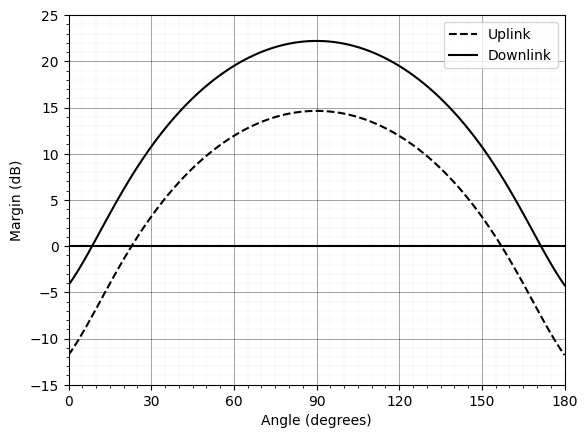

In [9]:
# Plot the margin as a function of the angle

# Generate angles
angles = np.linspace(0, 180, 100)

# Calculate margins
uplink_margin = calculate_margin(angles, 'up')
downlink_margin = calculate_margin(angles, 'down')

# Set the desired plot range
x_range = (0, 180)
y_range = (-15, 25)

# Create the plot
plt.plot(angles, uplink_margin, label='Uplink', color='black', linestyle='--')
plt.plot(angles, downlink_margin, label='Downlink', color='black', linestyle='-')
plt.legend()

# Set x-axis and y-axis labels
plt.xlabel('Angle (degrees)')
plt.ylabel('Margin (dB)')

# Set the plot range for the x-axis and y-axis
plt.xlim(x_range)
plt.ylim(y_range)

# Create grid lines
major_grid_dB = np.arange(np.floor(y_range[0] / 5) * 5, np.ceil(y_range[1] / 5) * 5 + 5, 5)
minor_grid_dB = np.arange(np.floor(y_range[0]), np.ceil(y_range[1]) + 1, 1)
major_grid_degrees = np.arange(0, 181, 30)  # Modified to have major ticks every 30 degrees
minor_grid_degrees = np.arange(0, 180, 5)

# Plot major grid lines
plt.grid(visible=True, which='major', axis='both', linestyle='-', linewidth=0.5, color='black', alpha=0.5)
plt.xticks(major_grid_degrees)
plt.yticks(major_grid_dB)

# Plot minor grid lines
plt.grid(visible=True, which='minor', axis='both', linestyle='-', linewidth=0.25, color='black', alpha=0.1)
plt.xticks(minor_grid_degrees, minor=True)
plt.yticks(minor_grid_dB, minor=True)

# Add bold line at y=0
plt.axhline(0, color='black', linewidth=1.5)

# Display the plot
plt.show()

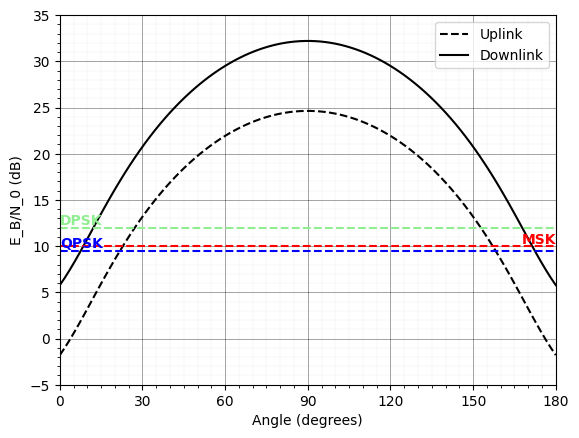

In [10]:
# Plot the received Eb/No as a function of the angle

# Generate angles
angles = np.linspace(0, 180, 100)

# Calculate margins
uplink_margin = calculate_EbNo(angles, 'up')
downlink_margin = calculate_EbNo(angles, 'down')

# Set the desired plot range
x_range = (0, 180)
y_range = (-5, 35)

# Create the plot
plt.plot(angles, uplink_margin, label='Uplink', color='black', linestyle='--')
plt.plot(angles, downlink_margin, label='Downlink', color='black', linestyle='-')
plt.legend()

# Set x-axis and y-axis labels
plt.xlabel('Angle (degrees)')
plt.ylabel('E_B/N_0 (dB)')

# Set the plot range for the x-axis and y-axis
plt.xlim(x_range)
plt.ylim(y_range)

# Create grid lines
major_grid_dB = np.arange(np.floor(y_range[0] / 5) * 5, np.ceil(y_range[1] / 5) * 5 + 5, 5)
minor_grid_dB = np.arange(np.floor(y_range[0]), np.ceil(y_range[1]) + 1, 1)
major_grid_degrees = np.arange(0, 181, 30)  # Modified to have major ticks every 30 degrees
minor_grid_degrees = np.arange(0, 180, 5)

# Plot major grid lines
plt.grid(visible=True, which='major', axis='both', linestyle='-', linewidth=0.5, color='black', alpha=0.5)
plt.xticks(major_grid_degrees)
plt.yticks(major_grid_dB)

# Plot minor grid lines
plt.grid(visible=True, which='minor', axis='both', linestyle='-', linewidth=0.25, color='black', alpha=0.1)
plt.xticks(minor_grid_degrees, minor=True)
plt.yticks(minor_grid_dB, minor=True)


plt_horizontal_line(10, color='red', name='MSK', name_place='right')
plt_horizontal_line(9.5, color='blue', name='QPSK', name_place='left')
plt_horizontal_line(12, color='lightgreen', name='DPSK', name_place='left')

# Display the plot
plt.show()